<a href="https://colab.research.google.com/github/marcelodepaoli/13_Regressao_Logistica/blob/main/01_Regress%C3%A3o_Log%C3%ADstica_com_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Regressão Logística com Python

Iremos trabalhar com o [Titanic Data Set](https://www.kaggle.com/c/titanic) obtido do Kaggle. Este é um conjunto de dados muito famoso e muitas vezes é o primeiro passo de um aluno em machine learning!

Tentaremos prever uma classificação: sobrevivência ou falecimento.
Vamos começar a compreensão da implementação da regressão logística em Python para classificação.

Usaremos uma versão "semi-limpa" do conjunto de dados do Titanic, se você usar o conjunto de dados hospedado diretamente no Kaggle, talvez seja necessário fazer algumas limpezas adicionais.

##Importar Bibliotecas

Vamos importar algumas bibliotecas para começar!

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

##Os Dados


Vamos começar lendo o arquivo titanic_train.csv em um pandas dataframe.

In [ ]:
# Esse trecho do código é obrigatório para quem estiver fazendo tudo pelo colab
# Caso você esteja utilizando o jupyter pode comentar/apagar
#import os
#from google.colab import drive

#drive.mount('/content/drive')
#os.chdir("drive/My Drive/Colab Notebooks/IA/13_Regressão_Logística")
#os.listdir()

In [ ]:
train = pd.read_csv('titanic_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#Exploratory Data Analysis

Vamos começar uma análise exploratória de dados! Começaremos verificando os dados ausentes!

##Missing Data

Podemos usar o seaborn para criar um mapa de calor simples para ver onde estão faltando dados!

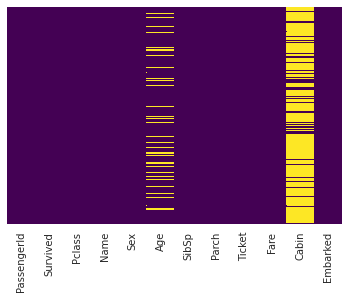

In [ ]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Cerca de 20 por cento dos dados de idade estão ausentes. A proporção de Idade ausente é, provavelmente, pequena o suficiente para que uma substituição com alguma forma de inputação fique razoável. Olhando para a coluna Cabine, no entanto, parece que um número excessivo destes dados estão faltando para se obter alguma informação útil com uma análise básica. Provavelmente vamos abandonar essa coluna ou alterá-la para uma outra característica como "Cabin Known: 1 ou 0"

Vamos continuar visualizando mais alguns dados!

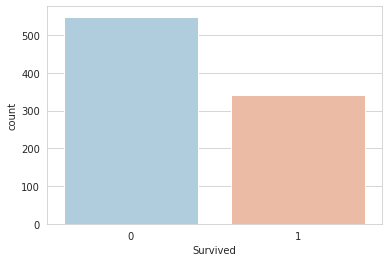

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

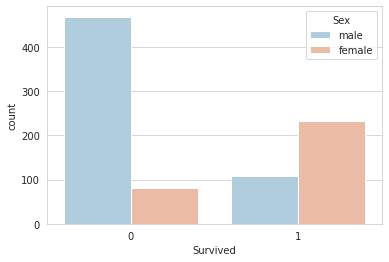

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

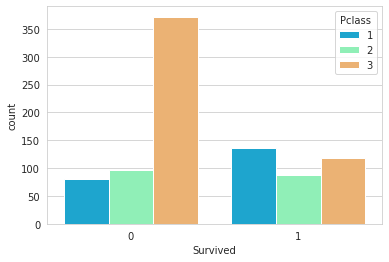

In [ ]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

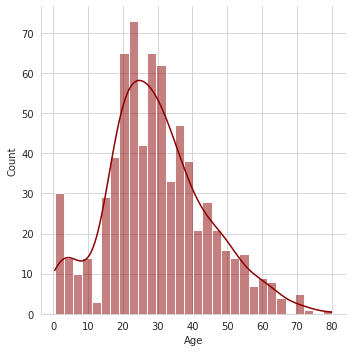

In [ ]:
sns.displot(train['Age'].dropna(),kde=True,color='darkred',bins=30)

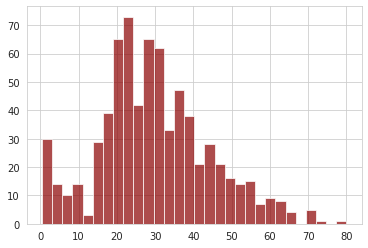

In [ ]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

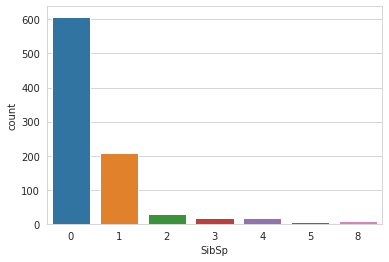

In [ ]:
sns.countplot(x='SibSp',data=train)

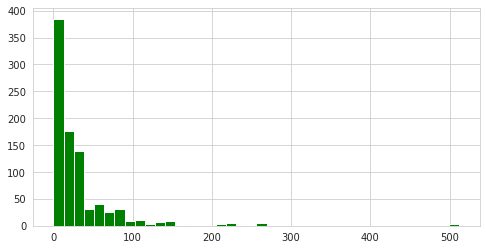

In [ ]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

##Data Cleaning

Queremos preencher os dados de idade ausentes em vez de apenas descartar as linhas de dados de idade ausentes. Uma forma de fazer isso é preenchendo com a idade média de todos os passageiros (imputação).

No entanto, podemos ser mais espertos quanto a isso e verificar a idade média por classe de passageiros. Por exemplo:


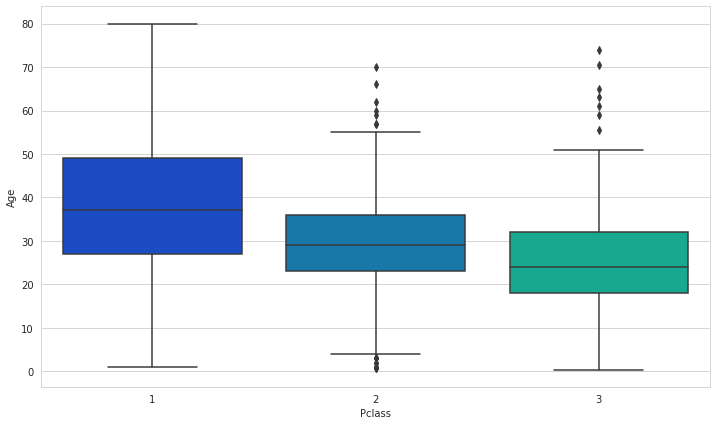

In [ ]:
plt.figure(figsize=(12,7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

Podemos ver que os passageiros nas classes mais altas (mais ricos) tendem a ser mais velhos. Usaremos esses valores de idade média para imputar com base em Pclass por Age.

In [ ]:
train.groupby('Pclass')['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [ ]:
def input_age(cols):
  Age = cols[0]
  Pclass = cols[1]

  if pd.isnull(Age):
    if Pclass == 1:
      return 38.2
    elif Pclass == 2:
      return 29.9
    else:
      return 25.1
  else:
    return Age

Aplicando essa função!

In [ ]:
train['Age'] = train[['Age','Pclass']].apply(input_age,axis=1)

Verificando o mapa de calor novamente!

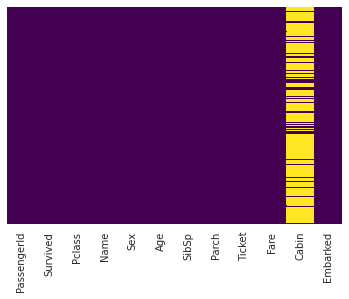

In [ ]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Excelente! Vamos em frente e remover a coluna Cabin e a linha em Embarked que é NaN.

In [ ]:
train.drop('Cabin',axis=1,inplace=True)
train.dropna(inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


##Convertendo Características Categóricas 

Precisaremos converter características categóricass em variáveis ​​fictícias usando pandas! Caso contrário, nosso algoritmo de aprendizado de máquina não poderá receber diretamente essas características como entradas.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [ ]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [ ]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [ ]:
train = pd.concat([train,sex,embark],axis=1)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


Excelente! Nossos dados estão prontos para o nosso modelo!

#Construindo um Modelo de Regressão Logística

Vamos começar dividindo nossos dados em um conjunto de treinamento e um conjunto de teste (há outro arquivo test.csv com o qual você pode brincar caso queira usar todos esses dados para treinamento).

##Train Test Split

In [ ]:
from sklearn.model_selection  import train_test_split

In [ ]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'male', 'Q', 'S'],
      dtype='object')

In [ ]:
X = train[['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare','male', 'Q', 'S']]
y = train['Survived']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

##Treinamento e Prevendo

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logmodel = LogisticRegression(solver='newton-cg')
logmodel.fit(X_train,y_train)

LogisticRegression(solver='newton-cg')

In [ ]:
predictions = logmodel.predict(X_test)

Vamos avaliar o modelo!

##Avaliação

Podemos verificar precision, recall, f1-score utilizando classification_report!

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       163
           1       0.84      0.68      0.75       104

    accuracy                           0.82       267
   macro avg       0.83      0.80      0.81       267
weighted avg       0.83      0.82      0.82       267



Não ficou tão ruim! Você pode explorar outras características e o outro arquivo titanic_test.csv, algumas sugestões:

* Tente utilizar o título (Dr., Mr., Mrs, etc.) do nome como uma característica
* Talvez a letra Cabin possa ser uma característica
* Existe alguma informação que você pode obter do bilhete (ticket)?